In [6]:
%pylab inline
import mlpy.wavelet as wave
import numpy as np
import matplotlib.pyplot as plt
import math
from IPython.html import widgets
from IPython.display import display, clear_output
import os
import pyfits
import urllib

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


In [7]:
def norm(x):
    """
    Normalize array x to range [0,1].
    """
    return (x-min(x)) / (max(x)-min(x))

####Load data

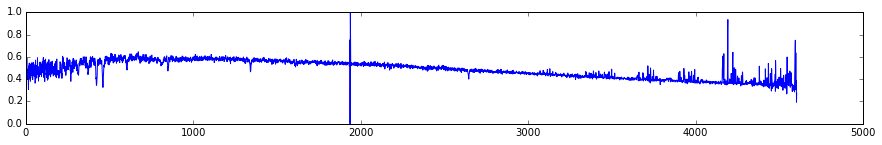

In [9]:
downlPath = '../data/download/'
telurPath = '../data/teluric/halfa/hc/'
filenames = os.listdir(telurPath)
fnW = widgets.Dropdown(description='File:', options=filenames)
fnBtn = widgets.Button(description="Load")
urlBtn = widgets.Button(description="Load")
urlW = widgets.Text(description='URL:', value='http://dr10.sdss3.org/sas/dr10/boss/spectro/redux/v5_5_12/spectra/4055/spec-4055-55359-0001.fits')
s = []

def download(url, fn):
    if not os.path.exists(fn):
        if not os.path.exists(downlPath):
            os.makedirs(downlPath)
        urllib.urlretrieve(url, fn)
        
def load(fn):
    global s
    ext = os.path.splitext(fn)[1]
    if ext in ('.fit', '.fits'):
        hdulist = pyfits.open(fn)
        if len(hdulist) > 1:
            # image
            fitsdata = hdulist[1].data
            s = [ fitsdata[i][0] for i in range(len(fitsdata)) ]
        else:
            # table
            s = hdulist[0].data
    else:
        s = np.genfromtxt(fn, delimiter='  ')
        s = s[:,1]
        
    s = norm(s)
    
    clear_output()
    plt.figure(num=1, figsize=(15,2))
    plt.plot(s)

def load_from_disk(_):
    fn = telurPath + fnW.value
    load(fn)
    
def load_from_url(_):
    fn = downlPath + os.path.basename(urlW.value)
    download(urlW.value, fn)
    load(fn)

    
fnBtn.on_click(load_from_disk)
urlBtn.on_click(load_from_url)

fn = widgets.HBox(children=(fnW, fnBtn))
url = widgets.HBox(children=(urlW, urlBtn))
display(fn, url)

#widgets.interactive(show, filename=specW, url=urlW)

####CWT, removing frequencies, reconstruction

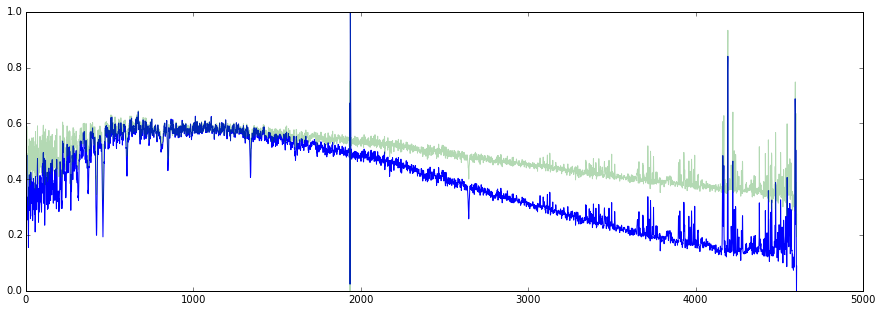

In [13]:
scales = []
coefs = []
wf = ''
p = 2

def cwt():
    global scales, coefs
    scales = wave.autoscales(N=s.shape[0], dt=1, dj=0.25, wf=wf, p=p)
    coefs = wave.cwt(s, dt=1, scales=scales, wf=wf, p=p)
    #print 'scales:', len(scales)
    #plt.figure(figsize=(10,10))
    #plt.imshow(np.abs(coefs), aspect=10)

def removeFreqs(freqs):
    """
    Remove frequencies interval freqs and reconstruct spectrum.
    freqs -- frequencies interval (tuple)
    wf -- wavelet function used for reconstruction
    """
    coefsZeros = np.concatenate((coefs[:freqs[0]], np.zeros((freqs[1]-freqs[0], len(coefs[0]))), coefs[freqs[1]:]))
    rec = wave.icwt(coefsZeros, dt=1, scales=scales, wf=wf, p=10)
    rec = norm(rec)

    plt.figure(figsize=(15,5))
    #plt.plot(s - rec)
    plt.plot(rec)
    plt.plot(s, alpha=0.3)
    #plt.title(specW.value)
    
def run(waveletFunction, removeFrequencies):
    global wf, p
    wfOld = '{} {}'.format(wf, p)
    wf, p = waveletFunction.split()
    p = int(p)
    
    if waveletFunction != wfOld:
        cwt()
    freqsW.max = len(scales)-1
    removeFreqs(removeFrequencies)
    
wfs = [
    'morlet 2', 'morlet 4', 'morlet 6',
    'paul 2', 'paul 4', 'paul 6',
    'dog 2', 'dog 6', 'dog 10',
]

wfW = widgets.Dropdown(options=wfs, value=wfs[0])
freqsW = widgets.IntRangeSlider(min=0, value=(0,10))

wfWI = widgets.interactive(run, waveletFunction=wfW, removeFrequencies=freqsW)
display(wfWI)

In [14]:
freqsCountSlider = widgets.IntSlider(min=1, max=len(scales)-1, step=1, value=10)
freqStartSlider = widgets.IntSlider(min=0, max=len(scales) - freqsCountSlider.value, step=1, value=0)
w = widgets.interactive(removeFreqs, freqsCount=freqsCountSlider, freqStart=freqStartSlider)

ValueError: cannot find widget or abbreviation for argument: 'freqs'